In [2]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from pathlib import Path, PureWindowsPath 
from Data import functions


from urllib.parse import urlparse
from cellpose import models

use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)
#Import of the necessary Modules:
import os
import re
import sys
import math
import time
from shutil import copy
from pathlib import Path, PureWindowsPath 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import skimage
import skimage.io
import skimage.filters as skf
import skimage.morphology as skm
from skimage.external.tifffile import TiffFile
from skimage.external.tifffile import TiffWriter
from scipy.ndimage.morphology import binary_fill_holes as fillHoles
from cellpose.models import Cellpose
import timeit

from skimage.external.tifffile import TiffFile
from skimage.external.tifffile import TiffWriter

import cv2

from tqdm.notebook import tqdm

TORCH CUDA version not installed/working.
>>> GPU activated? 0


to do:
- change min max radius parameters so that in one run of the folder circles are found in all images
- if not too late, change folder 400/500

In [3]:
directory = 'Data/test_maria/'
files = []
for file in Path(directory).iterdir():
    if str(file).endswith('tif'):
        files.append(str(file))
#files = [directory + '20201123_hSI_recSato_batch1_D5_3.tif' ]
imgs = [skimage.io.imread(f, as_gray=True) for f in files]
nimg = len(imgs)

For file 20210222_mLOrg_D14._16.tif the following 51 organoids have been detected


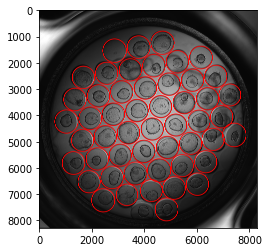

Data/test_maria/output/20210222_mLOrg_D14._16/
Data/test_maria/output/all/


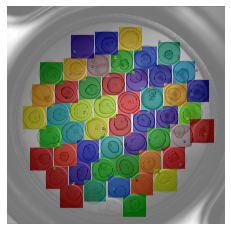

Time for file  1 :  26.013699555999665  s




In [6]:
Path(directory + 'output/').mkdir(exist_ok=True)
Path(directory + 'output/all').mkdir(exist_ok=True)

imageCount = 0

for file in tqdm(files):
    startImageTime = timeit.default_timer()
    image = cv2.imread(file)

    output = image.copy()
    height, width = image.shape[:2]
    # 16 ==> 83
    maxRadius = int(1.1*(width/10)/2)
    minRadius = int(0.9*(width/10)/2)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(image=gray, 
                               method=cv2.HOUGH_GRADIENT, 
                               dp=1.2, 
                               minDist=2*minRadius,
                               param1=50,
                               param2=50,
                               minRadius=minRadius,
                               maxRadius=maxRadius                           
                          )
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circlesRound = np.round(circles[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circlesRound:
            cv2.circle(output, (x, y), r, (255, 0, 0), 30)
            #cv2.rectangle(output, (x-r, y+r), (x+r, y-r), (0,0,255), 30)
        print('For file {0} the following {1} organoids have been detected'.format(file.rpartition('/')[-1], len(circles[0])))
        plt.imshow(output)
        plt.show()
    else:
        print ('No circles found')

    
    finalCentroids = [(c[0], c[1]) for c in circlesRound]
    radius = [c[2] for c in circlesRound]
    imageInitial = np.asarray(image)[:,:,0]
    
    squaresList = [returnSquare(finalCentroids[i], radius[i], imageInitial) for i in range(len(radius))]
    
    # 'Data/test_maria/20210222_mLOrg_D14._16.tif'
    
    Path(directory + 'output/' + file.rpartition('/')[-1][:-4]).mkdir(exist_ok=True)

   # patt2 = re.compile("\\\\") #""\\"" is the path-separator character used by the current OS.
   # patt3 = re.compile(r".tif+$")
   # moFullPath = re.split(patt2, file)
   # outFolder = ""
   # for part in moFullPath[1: -1]:
   #     outFolder = outFolder + part + "\\"
   # finalPart = moFullPath[-1].replace(" ", "_")
   # finalPart = re.split(patt3, finalPart)[0]
   # outFolder1 = outFolder + 'output/' + finalPart
   # print(outFolder)
    
    #put images on output/folder_named_after_img/
    outFolder1 = directory + 'output/' + file.rpartition('/')[-1][:-4] +'/'
    print(outFolder1)
    
    outFolder2 = directory + 'output/all/'
    print(outFolder2)
    
    croppedAreasImage = np.ones((imageInitial.shape[-2], imageInitial.shape[-1], 4))
    #print(imageInitial.shape)
    #print(croppedAreasImage[2090,4393])
    #Create a matplotilb.Figure and associated Axes:
    figCrop, axCrop = plt.subplots(1)
    #Create a random color arrangement for the squares and the text on top of them.
    randomValueSquare = []
    randomValueText = []
    for ind in range(0, len(squaresList), 1):
        #Attribute a random value from 0-255 to the pixels of each square. This will result in different colors,
        #taken from the colormap "nipy_spectral":
        randomValue = np.random.randint(0, 256, size = 1, dtype = np.uint8)[0]
        randomValueSquare.append(randomValue)
        #This should make possible to have a color for text on the squares that is different enough from the color
        #of the background square:
        randomValueText.append(np.uint8(255 - randomValue))
    #This is the colormap I will use. I need to instantiate it because I want to get the color values (rgba 0-1)
    #for the text (starting from the list of random values of "randomValueText")
    nipy_spectral_cm = matplotlib.cm.get_cmap("nipy_spectral")

    #Create the squares in the array and place the text objects on the image: 
    for ind, square in enumerate(squaresList, 0):
        #print(square[0])
        #print(square[1])
        croppedAreasImage[square[1], square[0], :] = nipy_spectral_cm(randomValueSquare[ind])
        text = ""
        if int(ind+1) < 10:
            text = "0" + str(ind+1)
        else:
            text = str(ind+1)
        axCrop.text(x = finalCentroids[ind][1], y = finalCentroids[ind][0], s = text, fontsize = 3,
                    color = nipy_spectral_cm(randomValueText[ind]), horizontalalignment = "center",
                    verticalalignment = "center")

    #Draw the original image and on top the array with all the squares. The text objects have been already
    #inserted by the lines above:
    axCrop.imshow(imageInitial, cmap = "gray", vmin = 0, vmax = 255)
    axCrop.imshow(croppedAreasImage, alpha = 0.45)
    axCrop.set_axis_off()
    figCrop.savefig(directory + file.rstrip('/')[-1][:-4] + "\\" + "Cropped_Areas.pdf", dpi = 200, format = "pdf", bbox_inches = "tight")
    plt.show(figCrop);


    #Save the wells as separated images:
    counter = 0
    for square in squaresList:
        counter = counter + 1
        filename = ""
        if counter < 10:
            filename = "0" + str(counter) + ".tif"
        else:
            filename = str(counter) + ".tif"
        #print('outfolder', outFolder)
        #print('filename', filename)
        path1 = outFolder1 + file.rstrip('/')[-1][:-5] + filename
        #print(path1)
        path2 = outFolder2 + file.rstrip('/')[-1][:-5] + filename
        #print(path2)
        #outFolder + "\\" + filename
        #Crop the single areas around aggregates and save them as separated files: 
        image = imageInitial[square[1].min():square[1].max(), square[0].min():square[0].max()]
        with TiffWriter(path1, bigtiff = False) as writer:
            writer.save(image)
            writer.close()
        with TiffWriter(path2, bigtiff = False) as writer:
            writer.save(image)
            writer.close()

    finalImageTime = timeit.default_timer()
    imageCount = imageCount + 1
    print("Time for file ", imageCount, ": ", finalImageTime-startImageTime, " s\n")


In [7]:
functions.segmentation('Data/test_maria/output/20210222_mLOrg_D14._16/')

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
Data/test_maria/output/20210222_mLOrg_D14._16/01.tif
Data/test_maria/output/20210222_mLOrg_D14._16/02.tif
Data/test_maria/output/20210222_mLOrg_D14._16/03.tif
Data/test_maria/output/20210222_mLOrg_D14._16/04.tif
Data/test_maria/output/20210222_mLOrg_D14._16/05.tif
Data/test_maria/output/20210222_mLOrg_D14._16/06.tif
Data/test_maria/output/20210222_mLOrg_D14._16/07.tif
Data/test_maria/output/20210222_mLOrg_D14._16/08.tif
Data/test_maria/output/20210222_mLOrg_D14._16/09.tif
Data/test_maria/output/20210222_mLOrg_D14._16/10.tif
Data/test_maria/output/20210222_mLOrg_D14._16/11.tif
Data/test_maria/output/20210222_mLOrg_D14._16/12.tif
Data/test_maria/output/20210222_mLOrg_D14._16/13.tif
Data/test_maria/output/20210222_mLOrg_D14._16/14.tif
Data/test_maria/output/20210222_mLOrg_D14._16/15.tif
Data/test_maria/output/20

Time for processing the file: 6.127247825000268 s . 


Data/test_maria/output/20210222_mLOrg_D14._16/

 21.tif
processing 1 image(s)
time spent: running network 1.51s; flow+mask computation 0.37
estimated masks for 1 image(s) in 1.90 sec
>>>> TOTAL TIME 1.90 sec
Time for processing the file: 6.5603364680000595 s . 


Data/test_maria/output/20210222_mLOrg_D14._16/

 22.tif
processing 1 image(s)
time spent: running network 1.44s; flow+mask computation 0.14
estimated masks for 1 image(s) in 1.60 sec
>>>> TOTAL TIME 1.60 sec
Time for processing the file: 6.1808420609995665 s . 


Data/test_maria/output/20210222_mLOrg_D14._16/

 23.tif
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.27
estimated masks for 1 image(s) in 1.38 sec
>>>> TOTAL TIME 1.38 sec
Time for processing the file: 6.227329328999986 s . 


Data/test_maria/output/20210222_mLOrg_D14._16/

 24.tif
processing 1 image(s)
time spent: running network 0.91s; flow+mask computation 0.22
estimated mask

time spent: running network 1.66s; flow+mask computation 0.58
estimated masks for 1 image(s) in 2.26 sec
>>>> TOTAL TIME 2.26 sec
Time for processing the file: 7.471829013999923 s . 


Processing all the 51 files took: 221.11634000899994 s .


In [5]:
def returnSquare(coords : tuple, radius : int, refImage : np.ndarray)-> np.ndarray:
    y = np.uint16(np.round(coords[0]))
    x = np.uint16(np.round(coords[1]))
    cols = np.array([pntX for pntX in range(x-radius, x+radius+1,1) if ((pntX >= 0) and (pntX <= refImage.shape[1]-1))])
    rows = np.array([pntY for pntY in range(y-radius, y+radius+1,1) if ((pntY >= 0) and (pntY <= refImage.shape[0]-1))])
    return np.array(np.meshgrid(rows, cols))